In [1]:
from libraries import lib
from libraries.NeuralStates import *
import qutip as qt
import torch.nn as nn 
import torch
import numpy as np
import matplotlib.pyplot as plt
from kan import *

In [2]:
def generate_eloc_distr(sampled_vector, N, J, Gamma, model):
    nn_output_calcs = {}
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output
    
    eloc_values = {}
    for basis_state in sampled_vector.distribution:
        eloc = 0
        output = model_to_output(basis_state)
        for adjacency in lib.generate_adjacencies(basis_state, N):
            output_prime = model_to_output(adjacency)
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_prime[0] - output[0] + 1.j * 2 * np.pi * (output_prime[1] - output[1]))
        eloc_values[basis_state] = eloc
    return eloc_values

def generate_input_samples(N, samples):
    return torch.tensor([lib.generate_state_array(x, N) for x in samples]).to(torch.float32)

In [3]:
def log_amp_phase(nn_output):
    return torch.exp(nn_output[:, 0] + 1.j * nn_output[:, 1])
def bitflip_x(x, N, flips):
    new_x = x
    for _ in range(flips):
        new_x = x ^ (1 << npr.randint(0, N))
    return new_x

In [4]:
N, J = 10, 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
input = lib.generate_input_torch(N)
num_epochs = 100
num_samples = 128
data_rate = 1

cpu


In [ ]:
Gamma = 1
true_gse = lib.ground_state_energy(Gamma, N)
print(true_gse)

kan_model = KAN(width=[N, N, 2], device=device)
epochs = []
energy_data = []
optimizer = torch.optim.Adam(kan_model.parameters(), lr=0.01)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, kan_model, log_amp_phase, lambda x : bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    eloc_distr = generate_eloc_distr(mh_state, N, J, Gamma, kan_model)
    eloc_list = torch.tensor([eloc_distr[x] for x in mh_state.list])
    psi = kan_model(generate_input_samples(N, mh_state.list))
    log_amp = psi[:, 0]; phase = psi[:, 1]
    eloc_r = eloc_list.real
    eloc_i = eloc_list.imag
    energy = eloc_r.mean()
    loss = ((eloc_r - eloc_r.mean()).detach() * log_amp + (eloc_i - eloc_i.mean()).detach() * phase).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy)
        epochs.append(epoch)
    print(epoch, energy)

# find groud state
gs = lib.model_to_ground_state(kan_model, input, log_amp_phase)
# 7 minutes

-12.784906442999326
checkpoint directory created: ./model
saving model version 0.0


c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\kan\MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1808.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\kan\MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1808.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\kan\MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (inpu

0 tensor(-9.4485)
1 tensor(-10.0050)
2 tensor(-10.1428)
3 tensor(-9.5114)
4 tensor(-10.1576)
5 tensor(-8.5473)
6 tensor(-9.4191)
7 tensor(-9.7410)
8 tensor(-9.6740)
9 tensor(-10.5534)
10 tensor(-10.4241)
11 tensor(-10.4146)
12 tensor(-10.5546)
13 tensor(-9.5877)
14 tensor(-9.7020)
15 tensor(-11.6173)
16 tensor(-10.4208)
17 tensor(-10.9725)
18 tensor(-10.7995)
19 tensor(-9.4558)
20 tensor(-10.1412)
21 tensor(-10.9290)
22 tensor(-9.7011)
23 tensor(-10.2765)
24 tensor(-11.4890)
25 tensor(-10.2244)
26 tensor(-9.7573)
27 tensor(-11.0731)
28 tensor(-10.8368)
29 tensor(-10.3810)
30 tensor(-10.7518)
31 tensor(-11.1675)
32 tensor(-11.1697)
33 tensor(-11.0101)
34 tensor(-11.3614)
35 tensor(-11.9305)
36 tensor(-11.7336)
37 tensor(-11.5000)
38 tensor(-11.1627)
39 tensor(-12.1686)
40 tensor(-12.6952)
41 tensor(-12.0957)
42 tensor(-12.2315)
43 tensor(-12.5481)
44 tensor(-12.2557)
45 tensor(-11.0340)
46 tensor(-12.1195)
47 tensor(-12.2384)
48 tensor(-11.6530)
49 tensor(-10.7139)
50 tensor(-12.5736)
5

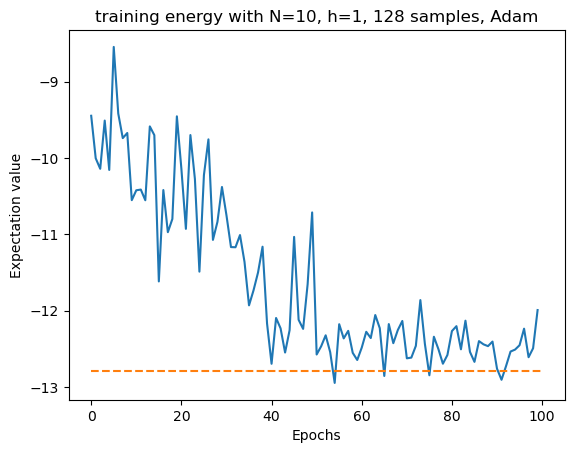

In [6]:
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [lib.ground_state_energy(Gamma, N)] * 2, linestyle = '--')
plt.title(f'training energy with N={N}, h={Gamma}, {num_samples} samples, Adam')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

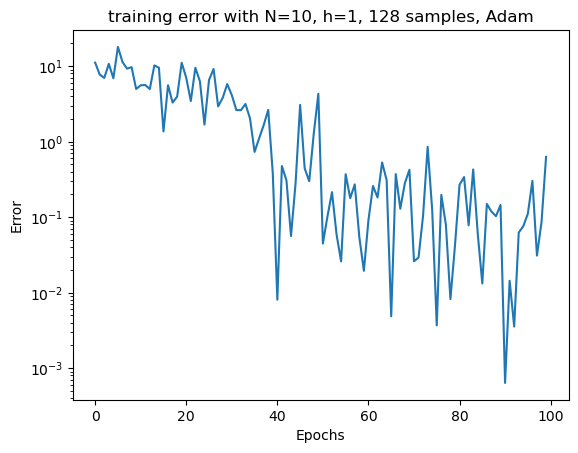

In [7]:
err = (np.array(energy_data) - true_gse) ** 2
plt.plot(epochs, err)
plt.title(f'training error with N={N}, h={Gamma}, {num_samples} samples, Adam')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.yscale('log')
plt.show()

In [8]:
eigs = lib.TFIM_hamiltonian(N, J, Gamma).eigenstates()
true_gs = eigs[1][0]
qt.fidelity(gs, true_gs)

np.float64(0.6981397575033826)

In [9]:
np.array(energy_data[200:]).std()

c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\numpy\_core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


np.float64(nan)

In [ ]:
Gamma = 0.1
true_gse = lib.ground_state_energy(Gamma, N)
print(true_gse)

kan_model = KAN(width=[N, N, 2], device=device)
epochs = []
energy_data = []
optimizer = torch.optim.Adam(kan_model.parameters(), lr=0.01)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, kan_model, log_amp_phase, lambda x : bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    eloc_distr = generate_eloc_distr(mh_state, N, J, Gamma, kan_model)
    eloc_list = torch.tensor([eloc_distr[x] for x in mh_state.list])
    psi = kan_model(generate_input_samples(N, mh_state.list))
    log_amp = psi[:, 0]; phase = psi[:, 1]
    eloc_r = eloc_list.real
    eloc_i = eloc_list.imag
    energy = eloc_r.mean()
    loss = ((eloc_r - eloc_r.mean()).detach() * log_amp + (eloc_i - eloc_i.mean()).detach() * phase).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy)
        epochs.append(epoch)
    print(epoch, energy)

# find groud state
gs = lib.model_to_ground_state(kan_model, input, log_amp_phase)
# 5 minutes

-10.025015664234306
checkpoint directory created: ./model
saving model version 0.0
0 tensor(-0.9448)
1 tensor(-1.2785)
2 tensor(-1.3688)
3 tensor(-0.7907)
4 tensor(-0.9514)
5 tensor(-0.2636)
6 tensor(-1.7346)
7 tensor(-0.7446)
8 tensor(-0.8234)
9 tensor(-1.3017)
10 tensor(-2.0473)
11 tensor(-0.9675)
12 tensor(-1.3298)
13 tensor(-0.7915)
14 tensor(-2.0523)
15 tensor(-2.6305)
16 tensor(-2.6156)
17 tensor(-1.7198)
18 tensor(-1.6083)
19 tensor(-1.3377)
20 tensor(-0.9986)
21 tensor(-1.7420)
22 tensor(-1.3569)
23 tensor(-1.6051)
24 tensor(-2.4634)
25 tensor(-2.5208)
26 tensor(-2.2738)
27 tensor(-3.0284)
28 tensor(-3.6070)
29 tensor(-3.4835)
30 tensor(-1.4939)
31 tensor(-4.1097)
32 tensor(-5.3333)
33 tensor(-2.6486)
34 tensor(-4.1028)
35 tensor(-4.9229)
36 tensor(-5.3903)
37 tensor(-4.8906)
38 tensor(-6.5666)
39 tensor(-6.4531)
40 tensor(-7.2127)
41 tensor(-5.5678)
42 tensor(-6.3428)
43 tensor(-7.6315)
44 tensor(-7.5855)
45 tensor(-7.6002)
46 tensor(-7.8150)
47 tensor(-8.8142)
48 tensor(-7.64

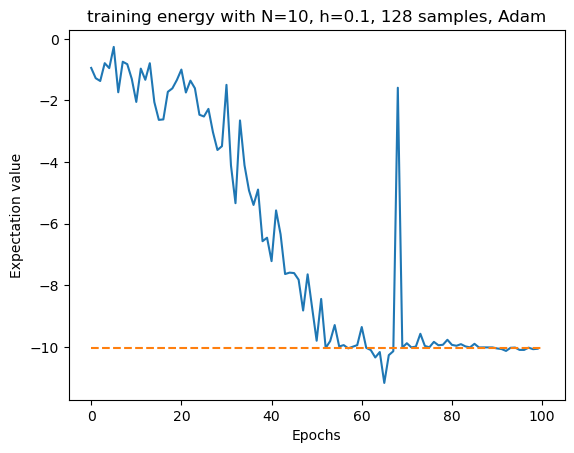

In [11]:
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [lib.ground_state_energy(Gamma, N)] * 2, linestyle = '--')
plt.title(f'training energy with N={N}, h={Gamma}, {num_samples} samples, Adam')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

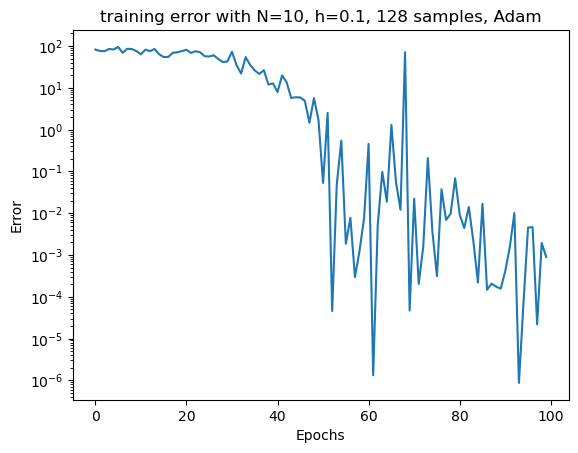

In [12]:
err = (np.array(energy_data) - true_gse) ** 2
plt.plot(epochs, err)
plt.title(f'training error with N={N}, h={Gamma}, {num_samples} samples, Adam')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.yscale('log')
plt.show()

In [13]:
eigs = lib.TFIM_hamiltonian(N, J, Gamma).eigenstates()
true_gs = eigs[1][0]
qt.fidelity(gs, true_gs)

np.float64(0.7063861704819343)

In [14]:
np.array(energy_data[200:]).std()

np.float64(nan)

In [ ]:
Gamma = 10
true_gse = lib.ground_state_energy(Gamma, N)
print(true_gse)

kan_model = KAN(width=[N, N, 2], device=device)
epochs = []
energy_data = []
optimizer = torch.optim.Adam(kan_model.parameters(), lr=0.01)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, kan_model, log_amp_phase, lambda x : bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    eloc_distr = generate_eloc_distr(mh_state, N, J, Gamma, kan_model)
    eloc_list = torch.tensor([eloc_distr[x] for x in mh_state.list])
    psi = kan_model(generate_input_samples(N, mh_state.list))
    log_amp = psi[:, 0]; phase = psi[:, 1]
    eloc_r = eloc_list.real
    eloc_i = eloc_list.imag
    energy = eloc_r.mean()
    loss = ((eloc_r - eloc_r.mean()).detach() * log_amp + (eloc_i - eloc_i.mean()).detach() * phase).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy)
        epochs.append(epoch)
    print(epoch, energy)

# find groud state
gs = lib.model_to_ground_state(kan_model, input, log_amp_phase)
# 15 minutes

-100.25015664234306
checkpoint directory created: ./model
saving model version 0.0
0 tensor(-94.4849)
1 tensor(-97.8200)
2 tensor(-97.7636)
3 tensor(-98.7874)
4 tensor(-99.6665)
5 tensor(-99.4501)
6 tensor(-99.6442)
7 tensor(-100.1498)
8 tensor(-98.8810)
9 tensor(-100.3184)
10 tensor(-99.3070)
11 tensor(-99.5138)
12 tensor(-100.1618)
13 tensor(-99.8835)
14 tensor(-99.9392)
15 tensor(-99.6459)
16 tensor(-99.6057)
17 tensor(-99.8716)
18 tensor(-100.1908)
19 tensor(-100.1769)
20 tensor(-99.5988)
21 tensor(-101.0173)
22 tensor(-100.0554)
23 tensor(-99.0259)
24 tensor(-99.2253)
25 tensor(-100.0920)
26 tensor(-100.7363)
27 tensor(-99.8338)
28 tensor(-100.0680)
29 tensor(-100.3707)
30 tensor(-99.8326)
31 tensor(-99.3538)
32 tensor(-100.3703)
33 tensor(-100.1372)
34 tensor(-100.9843)
35 tensor(-100.5176)
36 tensor(-99.4199)
37 tensor(-99.6635)
38 tensor(-100.9523)
39 tensor(-100.4367)
40 tensor(-100.3188)
41 tensor(-100.7120)
42 tensor(-99.8267)
43 tensor(-99.8510)
44 tensor(-99.1842)
45 tenso

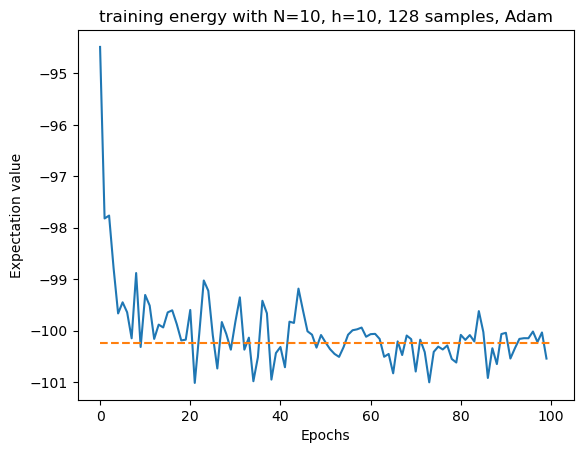

In [16]:
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [lib.ground_state_energy(Gamma, N)] * 2, linestyle = '--')
plt.title(f'training energy with N={N}, h={Gamma}, {num_samples} samples, Adam')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

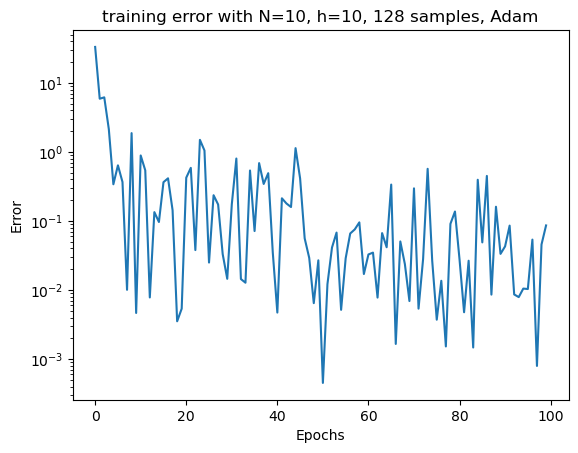

In [17]:
err = (np.array(energy_data) - true_gse) ** 2
plt.plot(epochs, err)
plt.title(f'training error with N={N}, h={Gamma}, {num_samples} samples, Adam')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.yscale('log')
plt.show()

In [18]:
eigs = lib.TFIM_hamiltonian(N, J, Gamma).eigenstates()
true_gs = eigs[1][0]
qt.fidelity(gs, true_gs)

np.float64(0.9995623231458851)

In [19]:
np.array(energy_data[200:]).std()

np.float64(nan)